In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

pd.options.mode.chained_assignment = None

In [2]:
# --------------------------------------------------------------
# Plot settings
# --------------------------------------------------------------

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [3]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle("../../data/interim/01_data_processed.pkl")
df = df[df["label"] != "rest"]

acc_r = df["acc_x"] ** 2 + df["acc_y"] ** 2 + df["acc_z"] ** 2
gyr_r = df["gyr_x"] ** 2 + df["gyr_y"] ** 2 + df["gyr_z"] ** 2

df["acc_r"] = np.sqrt(acc_r)
df["gyr_r"] = np.sqrt(gyr_r)

In [4]:
# --------------------------------------------------------------
# Split data
# --------------------------------------------------------------

bench_df = df[df["label"] == "bench"]
squat_df = df[df["label"] == "squat"]
row_df = df[df["label"] == "row"]
ohp_df = df[df["label"] == "ohp"]
dead_df = df[df["label"] == "dead"]

print(f"Number of Rows for Bench: {len(bench_df)}")
print(f"Number of Rows for Squat: {len(squat_df)}")
print(f"Number of Rows for Row: {len(row_df)}")
print(f"Number of Rows for Ohp: {len(ohp_df)}")
print(f"Number of Rows for Dead: {len(dead_df)}")

Number of Rows for Bench: 1665
Number of Rows for Squat: 1610
Number of Rows for Row: 1417
Number of Rows for Ohp: 1676
Number of Rows for Dead: 1531


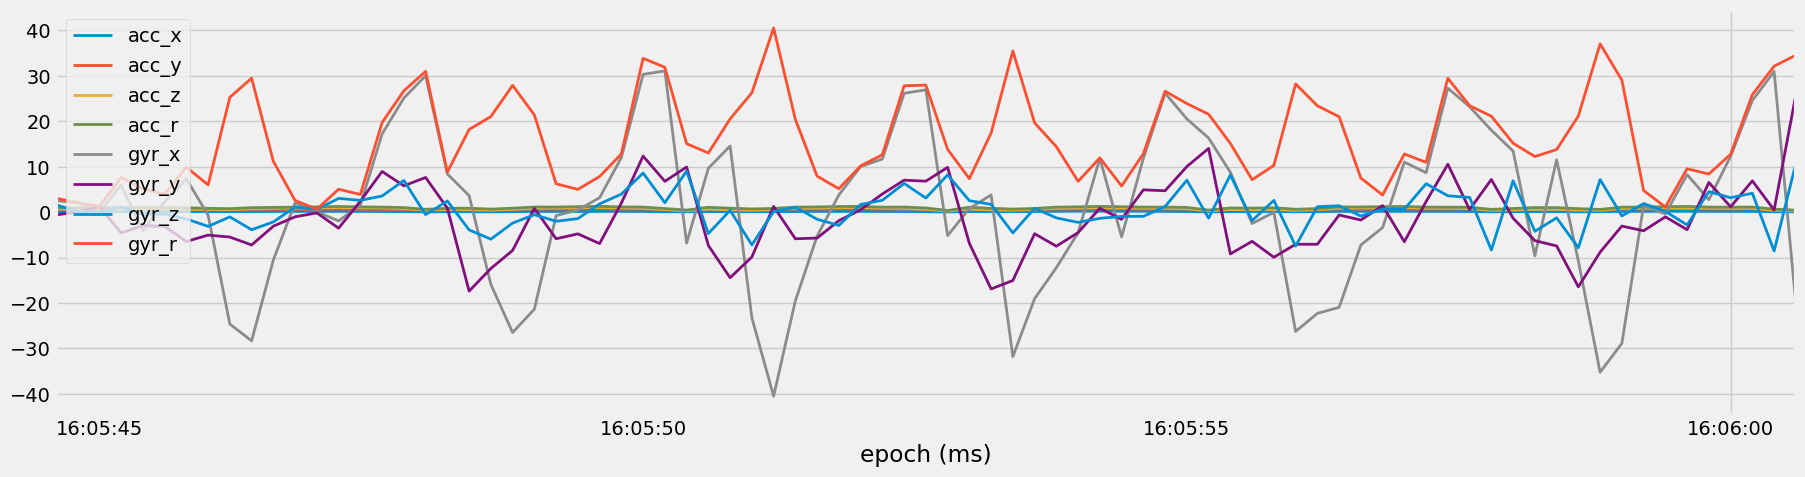

In [5]:
# --------------------------------------------------------------
# Visualize data to identify patterns
# --------------------------------------------------------------

plot_df = squat_df

plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_x"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_y"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_z"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_r"].plot()

plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_x"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_y"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_z"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_r"].plot()

plt.legend(loc = "upper left")
plt.show()

In [6]:
# --------------------------------------------------------------
# Configure LowPassFilter
# --------------------------------------------------------------

fs = 1000 / 200
LowPass = LowPassFilter()

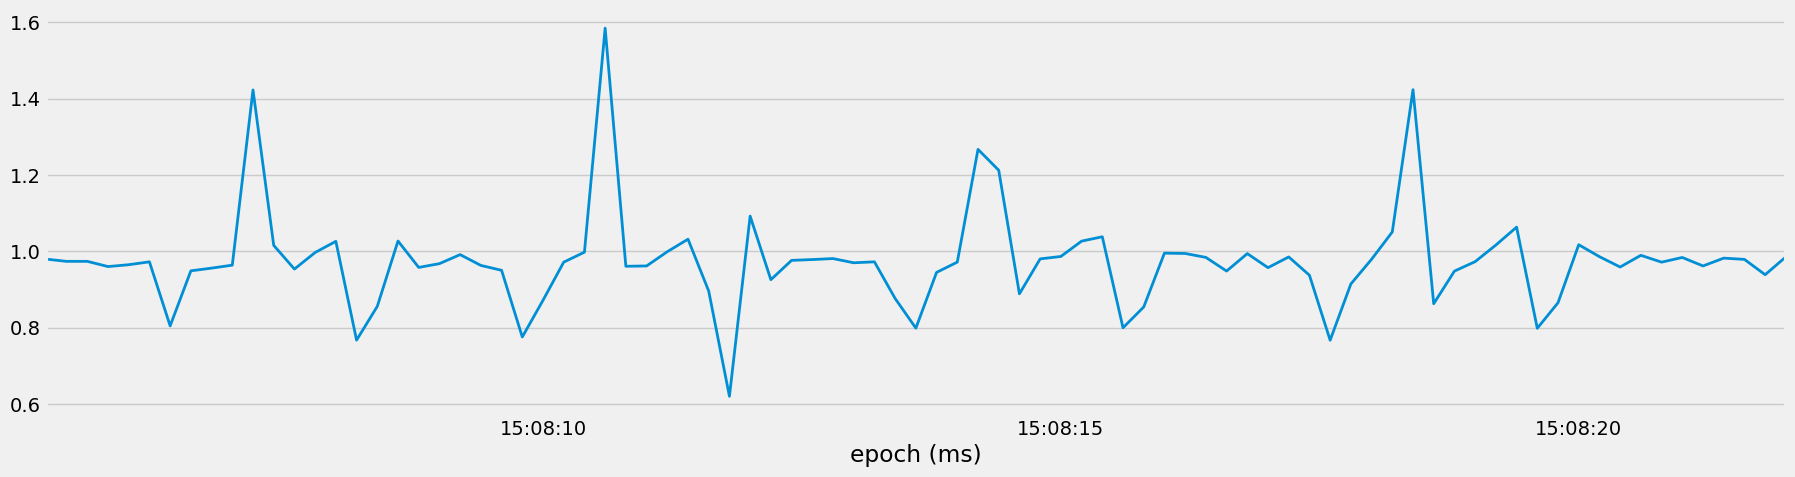

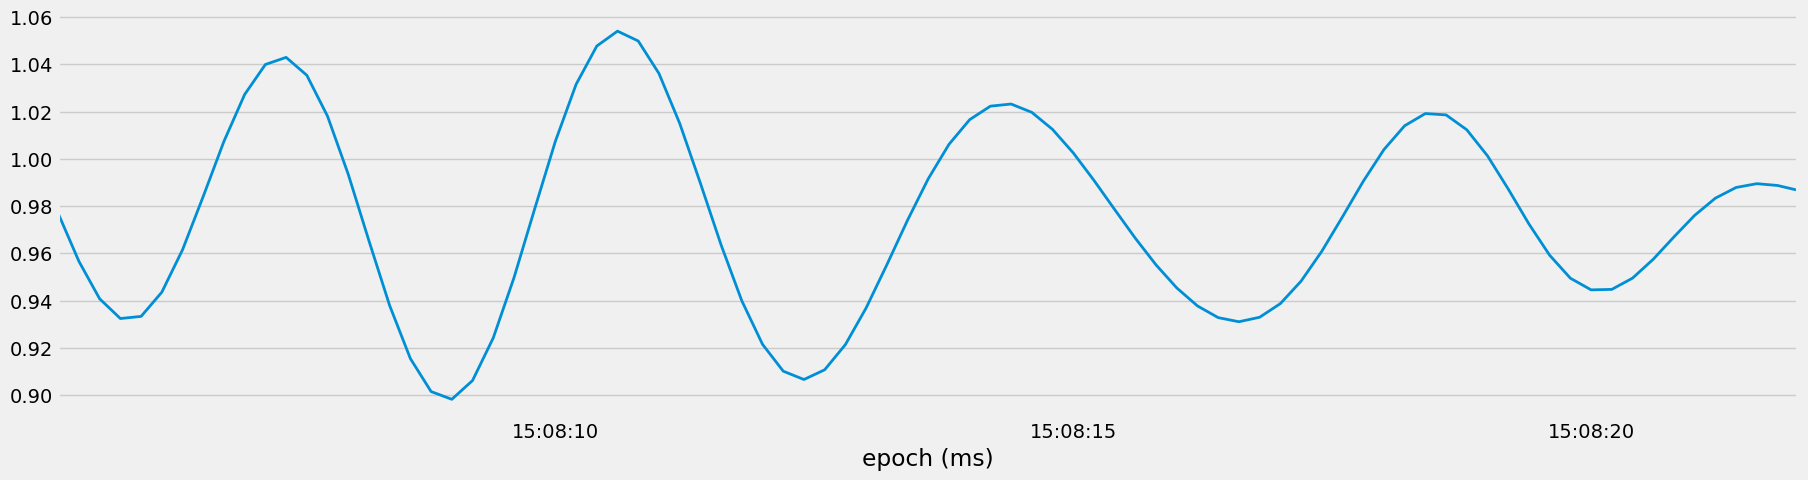

In [7]:
# --------------------------------------------------------------
# Apply and tweak LowPassFilter
# --------------------------------------------------------------

bench_set = bench_df[bench_df["set"] == bench_df["set"].unique()[0]]
squat_set = squat_df[squat_df["set"] == squat_df["set"].unique()[0]]
row_set = row_df[row_df["set"] == row_df["set"].unique()[0]]
ohp_set = ohp_df[ohp_df["set"] == ohp_df["set"].unique()[0]]
dead_set = dead_df[dead_df["set"] == dead_df["set"].unique()[0]]

plt.figure()
bench_set["acc_r"].plot()
plt.show()

plt.figure()
column = "acc_r"
LowPass.low_pass_filter(bench_set, col=column, sampling_frequency=fs, cutoff_frequency=0.4,
  order = 10)[column + "_lowpass"].plot()
plt.show()

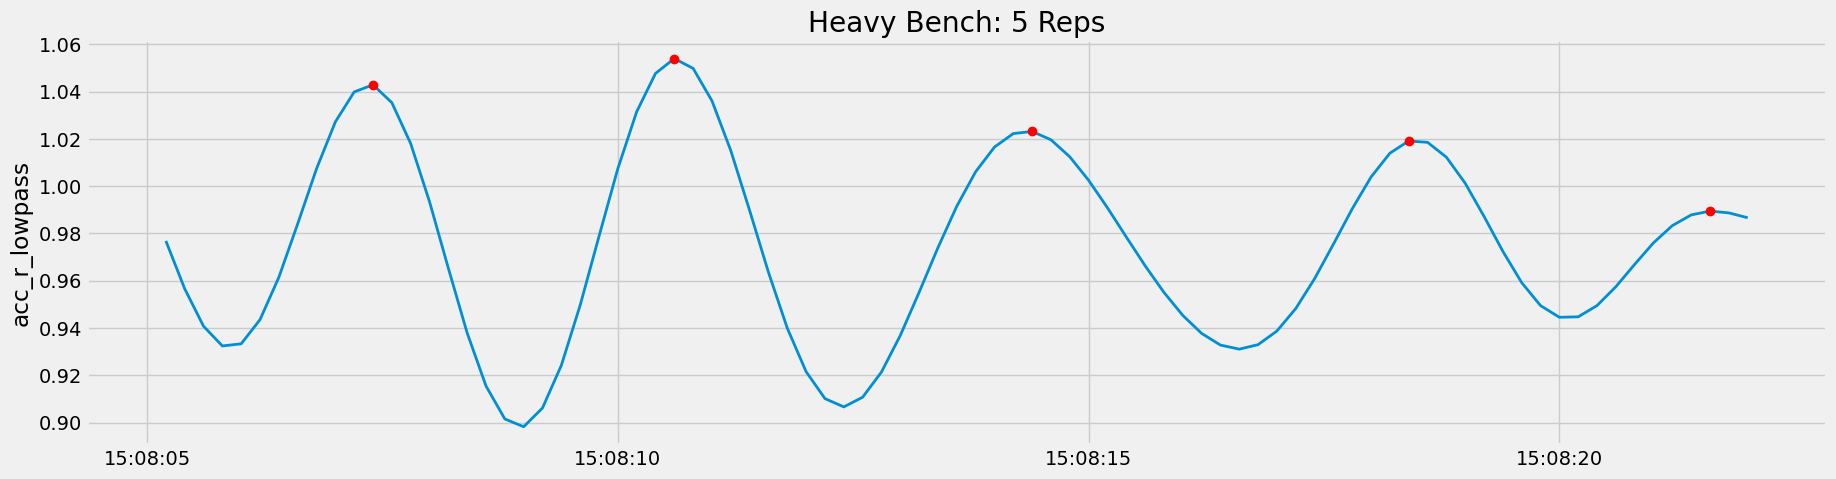

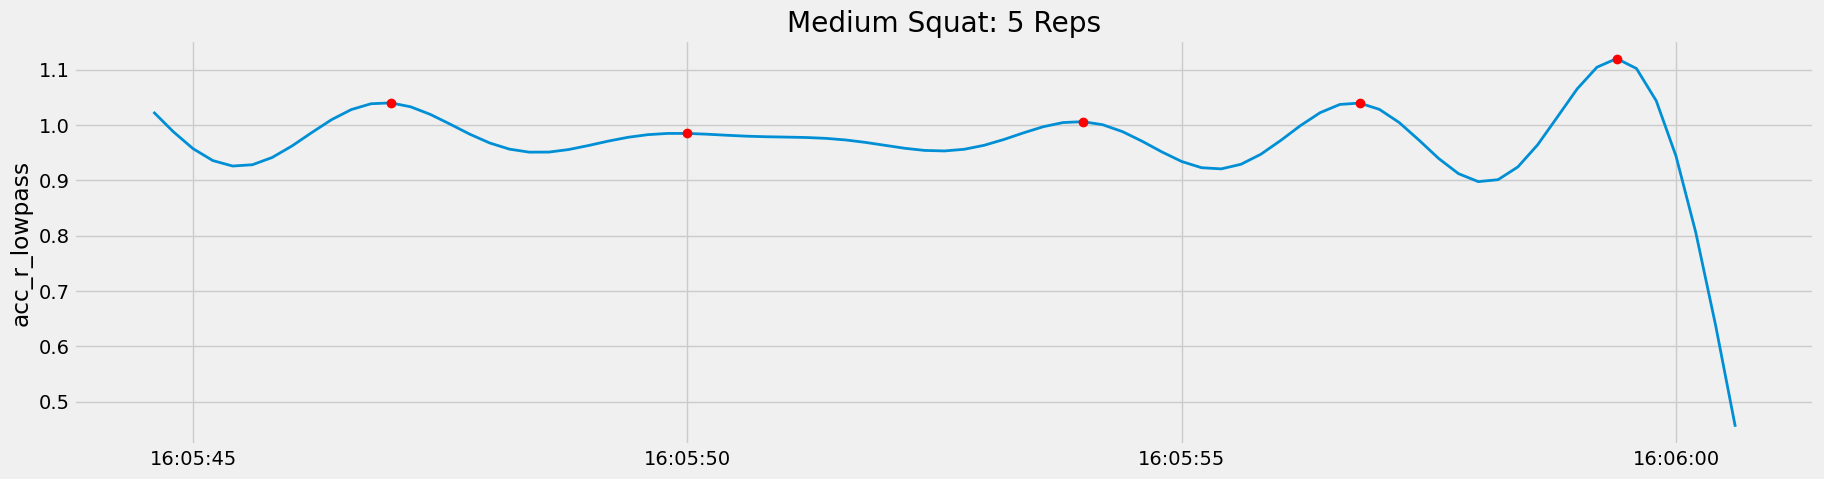

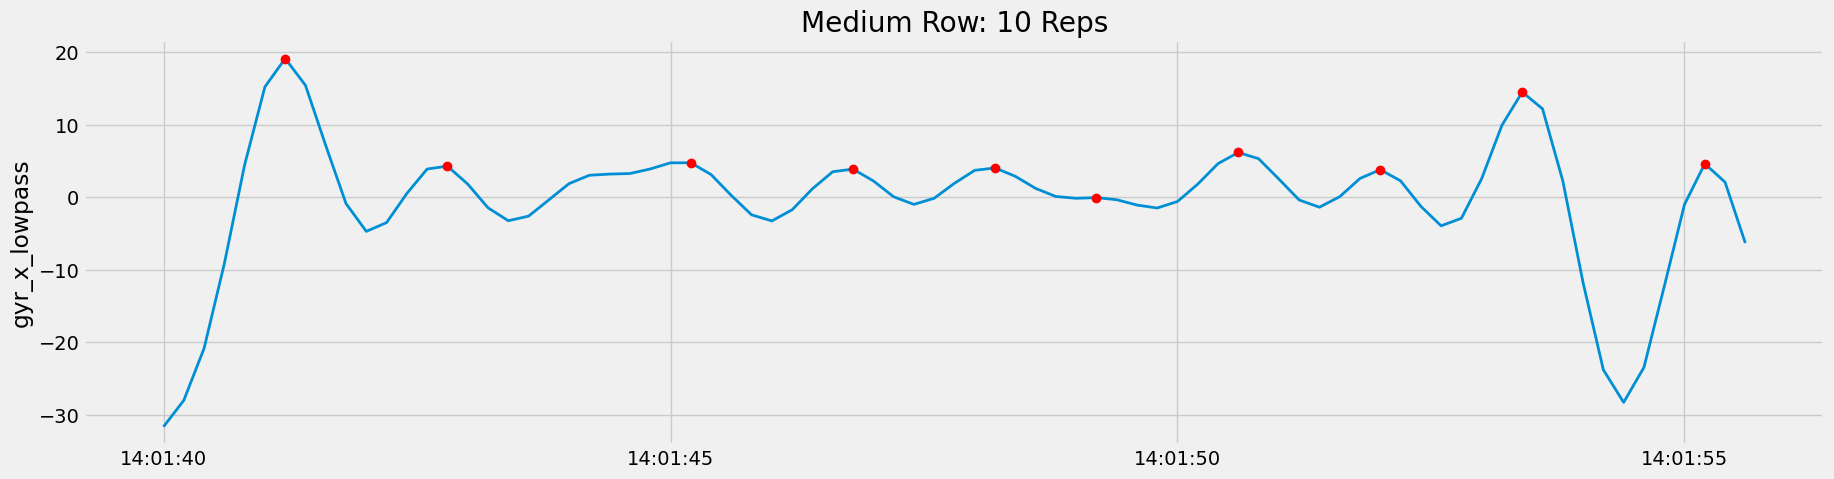

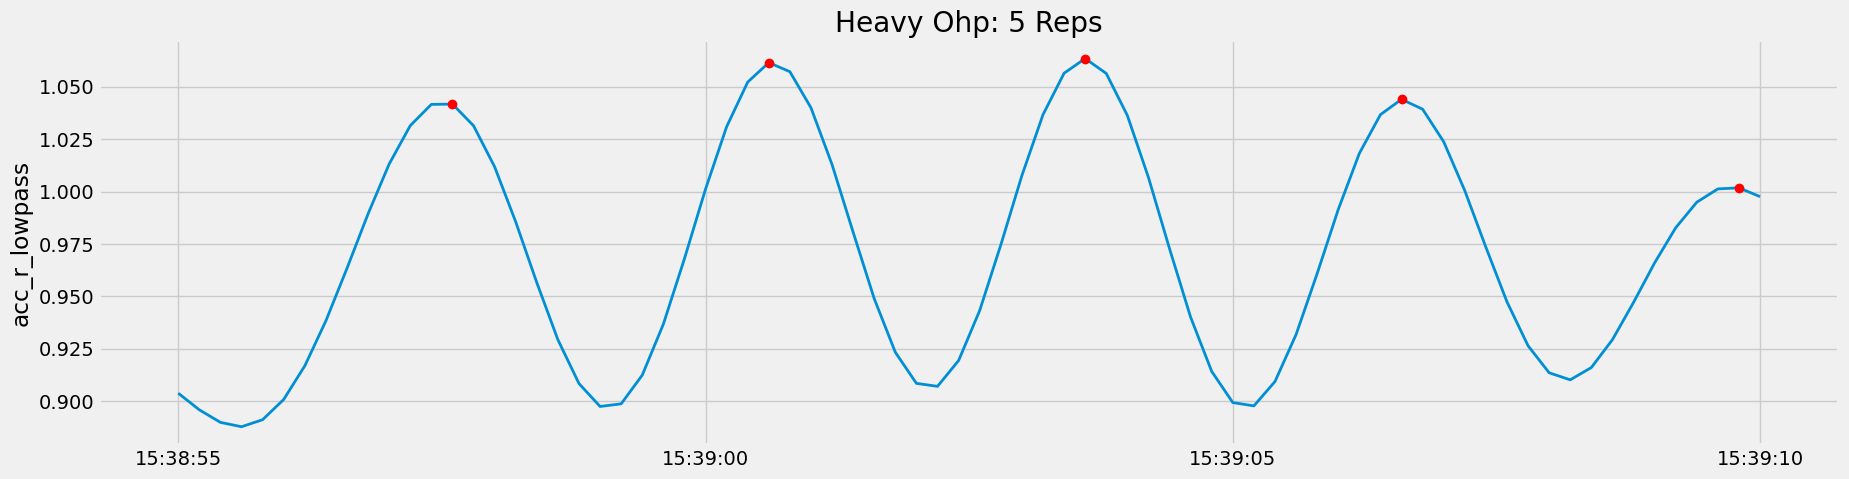

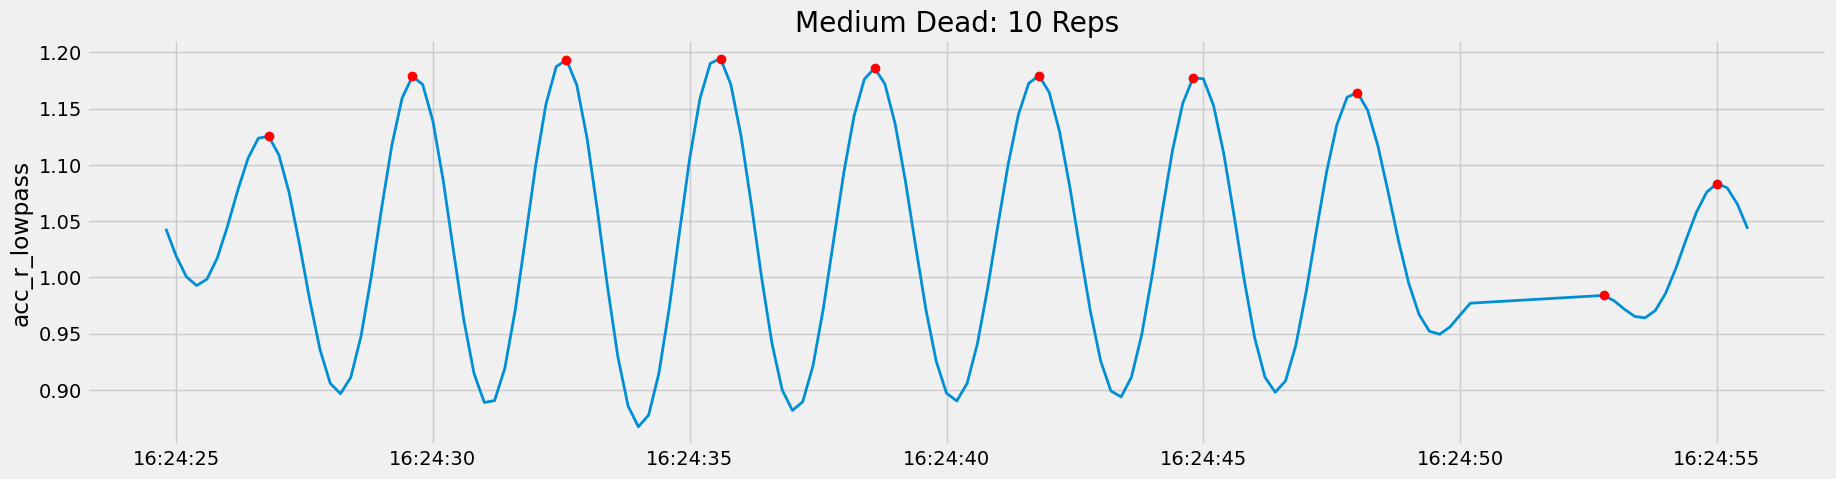

10

In [8]:
# --------------------------------------------------------------
# Create function to count repetitions
# --------------------------------------------------------------

def count_reps(dataset, cutoff=0.4, order=10, column="acc_r"):
  data = LowPass.low_pass_filter(
    dataset, col=column, sampling_frequency=fs, cutoff_frequency=cutoff, order=order
  )
  indexes = argrelextrema(data[column + "_lowpass"].values, np.greater)
  peaks = data.iloc[indexes]

  fig, ax = plt.subplots()
  plt.plot(dataset[f"{column}_lowpass"])
  plt.plot(peaks[f"{column}_lowpass"], "o", color="red")
  ax.set_ylabel(f"{column}_lowpass")
  exercise = dataset["label"].iloc[0].title()
  caegory = dataset["category"].iloc[0].title()
  plt.title(f"{caegory} {exercise}: {len(peaks)} Reps")
  plt.show()

  return len(peaks)


count_reps(bench_set, cutoff=0.4)
count_reps(squat_set, cutoff=0.35)
count_reps(row_set, cutoff=0.65, column="gyr_x")
count_reps(ohp_set, cutoff=0.35)
count_reps(dead_set, cutoff=0.4)

In [9]:
# --------------------------------------------------------------
# Function to count repetitions
# --------------------------------------------------------------

def count_reps(dataset, cutoff=0.4, order=10, column="acc_r"):
  data = LowPass.low_pass_filter(
    dataset, col=column, sampling_frequency=fs, cutoff_frequency=cutoff, order=order
  )
  indexes = argrelextrema(data[column + "_lowpass"].values, np.greater)
  peaks = data.iloc[indexes]

  return len(peaks)

In [ ]:
# --------------------------------------------------------------
# Create benchmark dataframe
# --------------------------------------------------------------

df["reps"] = df["category"].apply(lambda x: 5 if x == "heavy" else 10)
rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()
rep_df["reps_pred"] = 0

for s in df["set"].unique():
  subset = df[df["set"] == s]

  column = "acc_r"
  cutoff = 0.4

  if subset["label"].iloc[0] == "squat":
    cutoff = 0.35

  if subset["label"].iloc[0] == "row":
    cutoff = 0.65
    col = "gyr_x"

  if subset["label"].iloc[0] == "ohp":
    cutoff = 0.35

  reps = count_reps(subset, cutoff=cutoff, column=column)
  rep_df.loc[rep_df["set"] == s, "reps_pred"] = reps

print(rep_df)

    label category  set  reps  reps_pred
0   bench    heavy    1     5          5
1   bench    heavy    2     5          4
2   bench    heavy    3     5          5
3   bench    heavy    4     5          5
4   bench    heavy   30     5          5
..    ...      ...  ...   ...        ...
80  squat   medium   28    10          8
81  squat   medium   29    10          8
82  squat   medium   38    10          7
83  squat   medium   63    10         11
84  squat   medium   64    10          9

[85 rows x 5 columns]


The Error is: 1.02


<Axes: xlabel='label,category'>

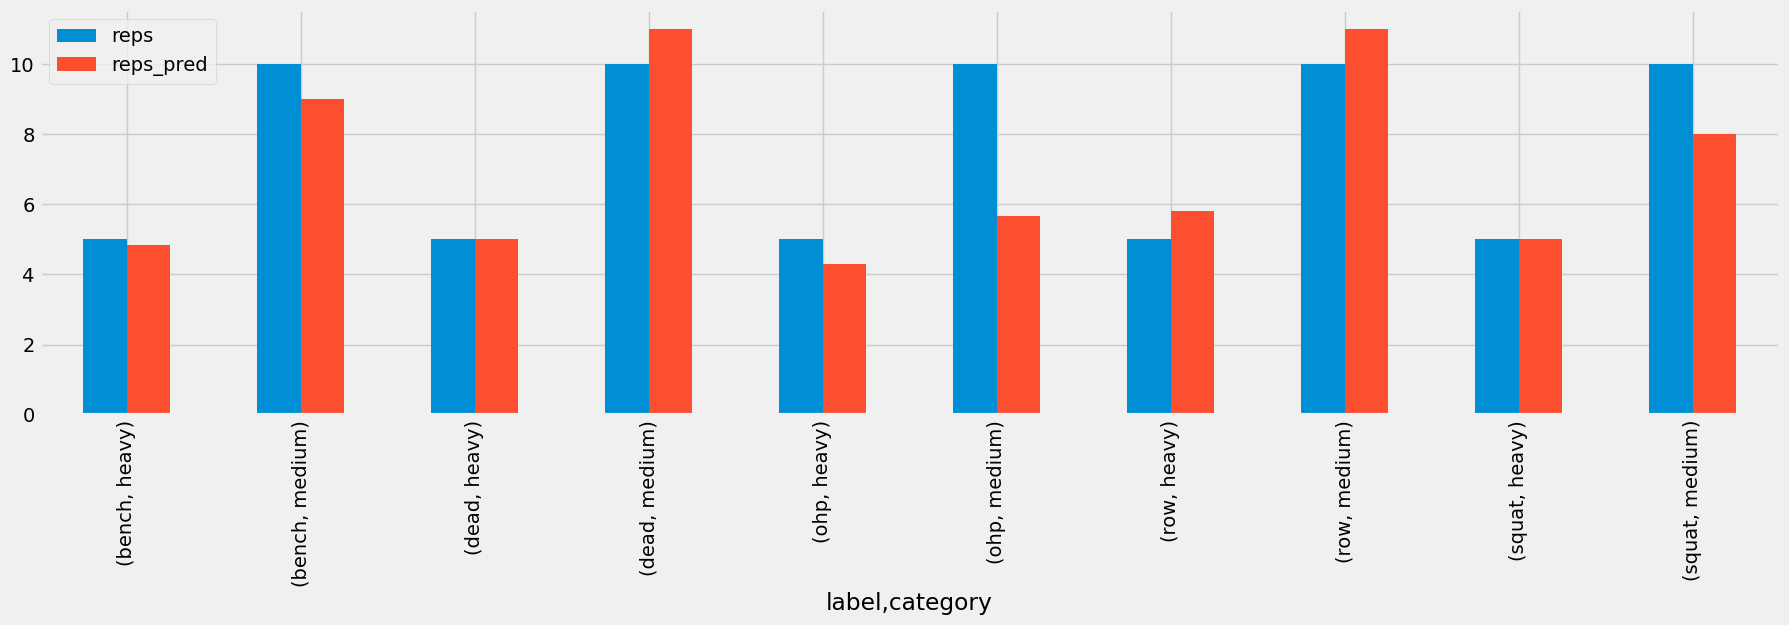

In [31]:
# --------------------------------------------------------------
# Evaluate the results
# --------------------------------------------------------------

error = round(mean_absolute_error(rep_df["reps"], rep_df["reps_pred"]), 2)
print(f"The Error is: {error}")

rep_df.groupby(["label", "category"])[["reps", "reps_pred"]].mean().plot.bar()